# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
features, target = next(train_gen_flow)
features.shape

(32, 224, 224, 3)

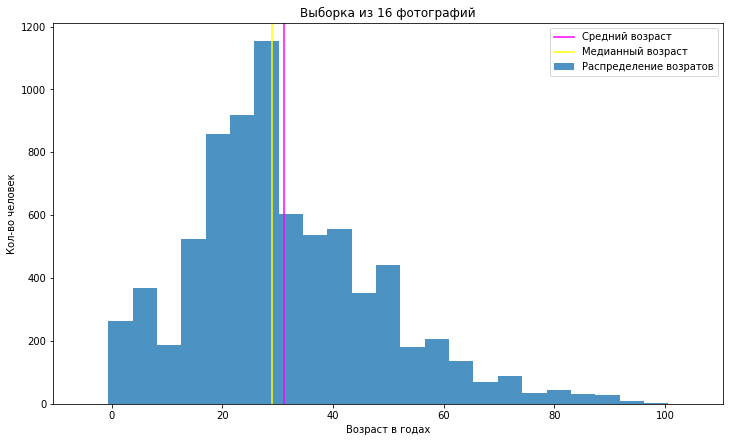

In [ ]:
plt.figure(figsize=(12, 7))
plt.hist(labels['real_age'], bins=25,
         range=(-5, 105), alpha=0.8,
         label='Распределение возратов')
plt.axvline(labels['real_age'].mean(),
            color='magenta', label='Средний возраст')
plt.axvline(labels['real_age'].median(),
            color='yellow', label='Медианный возраст')
plt.title('Выборка из 16 фотографий')
plt.xlabel('Возраст в годах')
plt.ylabel("Кол-во человек")
plt.legend()
plt.show()

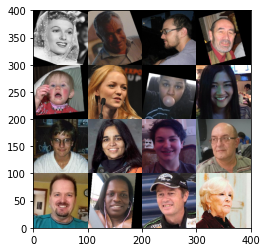

In [ ]:
fig, ax = plt.subplots()

x = 0
y = 0

for i in range(16):
    ax.imshow(features[i], extent=[x, x+100, y, y+100])
    x += 100
    if x >= 400:
        x = 0
        y += 100

ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
fig
plt.show()

**Вывод:** Выборка из 16 фотографий (представляющая менее 1% всех данных) показала, что в данных содержатся как цветные так и черно-белые фотографии различного размера и качества.

Также, заметно, что некоторые фото повернуты на некоторое кол-во градусов в сторону, что может означать применимость такой же аугментации ко всему набору данных. Различное качетсво фото может быть решено добавлением приближения фотографий. Также не помешает и горизонталеьное отражение, а вот вертикальное будет очень сильно выбиваться и может "зауптать" модель.

ОТносительно распределения возрастов в данных, можно сказать, что на большей части фотографий запучателены люди в возрасте от 18 до 35 лет, и дети от 0 до 10 лет. Страшего поколения ожидаемо меньше.

## Обучение модели

```python
import pandas as pd
import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      validation_split=0.2,
                                      horizontal_flip=True,
                                      zoom_range=0.2)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow


def load_test(path):
    labels_test = pd.read_csv(path + 'labels.csv')
    print(labels_test)
    test_datagen = ImageDataGenerator(rescale=1/255,
                                      validation_split=0.2)
    print(test_datagen)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels_test,
        directory=(path + '/final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow


def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                     activation='relu', input_shape=input_shape,
                     kernel_initializer=GlorotNormal(seed=123)))
    model.add(BatchNormalization())  # new
    model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same',
                  activation='relu'))
    model.add(BatchNormalization())  # new
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                  activation='relu'))
    model.add(BatchNormalization())  # new
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                  activation='relu'))
    model.add(BatchNormalization())  # new
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                  activation='relu'))
    model.add(BatchNormalization())  # new
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same',
                  activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same',
                  activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(units=1024, activation='relu',
                    kernel_initializer=GlorotNormal(seed=123),
                    kernel_regularizer='l1'))
    model.add(Dropout(0.2))  # new
    model.add(Dense(units=512, activation='relu', kernel_regularizer='l1'))
    #model.add(Dropout(0.2))
    #model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1))

    model.compile(loss='mean_squared_error', optimizer=Adamax(), metrics=['mae'])
    model.summary()

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=42,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model
```

```
Epoch 1/42
2024-07-19 19:55:06.401367: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-19 19:55:06.777767: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
380/380 - 129s - loss: 1452.0422 - mae: 13.1424 - val_loss: 1294.2115 - val_mae: 14.2282
Epoch 2/42
380/380 - 113s - loss: 1042.3012 - mae: 11.9040 - val_loss: 903.1170 - val_mae: 11.9636
Epoch 3/42
380/380 - 112s - loss: 801.2498 - mae: 11.2703 - val_loss: 705.1586 - val_mae: 10.9495
Epoch 4/42
380/380 - 112s - loss: 630.3394 - mae: 10.8046 - val_loss: 603.1558 - val_mae: 11.6488
Epoch 5/42
380/380 - 111s - loss: 500.1972 - mae: 10.3487 - val_loss: 444.3913 - val_mae: 10.3573
Epoch 6/42
380/380 - 113s - loss: 413.0537 - mae: 9.9926 - val_loss: 374.4393 - val_mae: 10.1044
Epoch 7/42
380/380 - 111s - loss: 341.7602 - mae: 9.6078 - val_loss: 335.8193 - val_mae: 10.3346
Epoch 8/42
380/380 - 104s - loss: 293.3546 - mae: 9.3379 - val_loss: 264.3691 - val_mae: 9.0976
Epoch 9/42
380/380 - 112s - loss: 259.1160 - mae: 9.0422 - val_loss: 255.5296 - val_mae: 8.9271
Epoch 10/42
380/380 - 113s - loss: 240.0478 - mae: 8.8139 - val_loss: 217.2598 - val_mae: 8.3064
Epoch 11/42
380/380 - 112s - loss: 217.6298 - mae: 8.5444 - val_loss: 245.7313 - val_mae: 9.4480
Epoch 12/42
380/380 - 112s - loss: 201.6539 - mae: 8.3072 - val_loss: 201.8926 - val_mae: 8.4177
Epoch 13/42
380/380 - 112s - loss: 188.1245 - mae: 8.1340 - val_loss: 200.2734 - val_mae: 8.7019
Epoch 14/42
380/380 - 112s - loss: 174.2100 - mae: 7.8812 - val_loss: 199.5757 - val_mae: 8.8035
Epoch 15/42
380/380 - 111s - loss: 166.0496 - mae: 7.7623 - val_loss: 167.5448 - val_mae: 7.9897
Epoch 16/42
380/380 - 113s - loss: 154.9375 - mae: 7.5651 - val_loss: 214.5946 - val_mae: 9.4835
Epoch 17/42
380/380 - 112s - loss: 148.3435 - mae: 7.4103 - val_loss: 177.0823 - val_mae: 8.3727
Epoch 18/42
380/380 - 113s - loss: 139.2404 - mae: 7.2163 - val_loss: 165.9419 - val_mae: 8.1098
Epoch 19/42
380/380 - 113s - loss: 133.6854 - mae: 7.0899 - val_loss: 156.4712 - val_mae: 7.8832
Epoch 20/42
380/380 - 111s - loss: 126.9817 - mae: 6.8746 - val_loss: 162.2388 - val_mae: 8.2338
Epoch 21/42
380/380 - 112s - loss: 121.9982 - mae: 6.7892 - val_loss: 170.8487 - val_mae: 8.4657
Epoch 22/42
380/380 - 114s - loss: 119.8972 - mae: 6.6686 - val_loss: 153.2746 - val_mae: 7.9713
Epoch 23/42
380/380 - 113s - loss: 114.5689 - mae: 6.5267 - val_loss: 166.5106 - val_mae: 8.4562
Epoch 24/42
380/380 - 113s - loss: 110.6098 - mae: 6.3850 - val_loss: 148.7544 - val_mae: 7.7678
Epoch 25/42
380/380 - 105s - loss: 106.7425 - mae: 6.2563 - val_loss: 149.0522 - val_mae: 7.8737
Epoch 26/42
380/380 - 112s - loss: 106.1917 - mae: 6.2679 - val_loss: 200.6596 - val_mae: 9.5413
Epoch 27/42
380/380 - 111s - loss: 102.0807 - mae: 6.1164 - val_loss: 166.3142 - val_mae: 8.4371
Epoch 28/42
380/380 - 103s - loss: 101.7483 - mae: 6.1311 - val_loss: 144.9460 - val_mae: 7.8297
Epoch 29/42
380/380 - 112s - loss: 96.5195 - mae: 5.9366 - val_loss: 150.5186 - val_mae: 7.9785
Epoch 30/42
380/380 - 113s - loss: 91.6650 - mae: 5.6884 - val_loss: 130.7352 - val_mae: 7.3215
Epoch 31/42
380/380 - 112s - loss: 92.3409 - mae: 5.7080 - val_loss: 176.6875 - val_mae: 8.7424
Epoch 32/42
380/380 - 112s - loss: 91.5758 - mae: 5.7115 - val_loss: 157.6808 - val_mae: 8.1330
Epoch 33/42
380/380 - 113s - loss: 87.3620 - mae: 5.5205 - val_loss: 144.4781 - val_mae: 7.7790
Epoch 34/42
380/380 - 112s - loss: 87.0701 - mae: 5.5520 - val_loss: 178.6288 - val_mae: 8.8928
Epoch 35/42
380/380 - 111s - loss: 84.1201 - mae: 5.3954 - val_loss: 151.0972 - val_mae: 8.1466
Epoch 36/42
380/380 - 112s - loss: 82.6622 - mae: 5.3516 - val_loss: 198.8069 - val_mae: 9.5612
Epoch 37/42
380/380 - 112s - loss: 80.5645 - mae: 5.2507 - val_loss: 148.2722 - val_mae: 7.9254
Epoch 38/42
380/380 - 112s - loss: 78.8518 - mae: 5.2118 - val_loss: 131.1446 - val_mae: 7.3888
Epoch 39/42
380/380 - 112s - loss: 78.9719 - mae: 5.2466 - val_loss: 149.2767 - val_mae: 7.9794
Epoch 40/42
380/380 - 113s - loss: 76.0964 - mae: 5.1129 - val_loss: 153.2800 - val_mae: 8.0490
Epoch 41/42
380/380 - 112s - loss: 76.1196 - mae: 5.0694 - val_loss: 199.5478 - val_mae: 9.6885
Epoch 42/42
380/380 - 108s - loss: 71.8634 - mae: 4.9005 - val_loss: 138.4385 - val_mae: 7.6244
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 138.4385 - mae: 7.6244
Test MAE: 7.6244

```

## Анализ обученной модели

Наилучшим образом себя показала модель с 5 блоками из светочных слоев с размером фильтра 3х3 и нормализацией после каждого сверточного слоя и пуллингом с уменьшением в два раза, после которых идут два полносвязных слоя. Количество фильтров растет от блока к блоку, начиная с 32, заканчивая 256 фильтрами. Финалные данные, которые передаются полносвязным слоям имеют форму 7х7х256.

Данная структура была составлена экспериментально после изучения структур AlexNet, ZFNet, VGG19 (не хотелось брать готовую). Если увеличивать кол-во слоев в блоках с бОльшим кол-вом фильтров(128, 256), модель быстро переобучается и не может достигнуть метрики ниже 10 даже после 50 эпох.  

Инициализатор весов - GlorotNormal, показал себя лучше других инициализаторов (а при использовании Хи-нормального тренажер падал с ошибкой "Этот код точно на языке Python?". Также оптимизатор Adamax помог достичь нужной метрики, а Adam почти не улучшал валидационную метрику. Также использование ругаляризатора ядра (l1) на полносвязных слоя вместе с Dropout слоем немного улучшили метрику (скорее всего из-за меньшего переобучения и большего умения обобщения).

Размер пакетов - 16, выбран на основе исследования нормализации пакетов (сказано, что при нормализации пакетов их меньшее кол-во способствует лучшему обучению, что оказалось так).

Касательно аугментаций, горизонтальное отражение помогло улучшить метрику. Вертикальное - наоборот, немного уменьшило.

Наилучшая метрика с этой моделью - 7.7 (МАЕ).

P.S. Очень хотелось бы еще улучшить метрику в этом задании, но совсем не получается(